In [1]:
from collections import defaultdict
import csv
from datetime import date
from pydantic import BaseModel
import pprint

class GameResult(BaseModel):
    date: date
    lobby: str  
    match: int
    team: str
    ign: str
    ign2: str = None
    playfabid: str
    playfabid2: str
    placement: int
    kills: int
    damage: int
    is_fun_match: bool
    team_size: int = None
    roster: set = None


class Stats(BaseModel):
    ign: str = None
    playfab: str = None
    team_size: int = None
    games: int = 0
    wr: float = 0.0
    kpg: float = 0.0
    dpg: float = 0.0
    orig_rating: float = None
    
    def add_game(self, place, kills, damage):
        win = 1.0 if place == 1 else 0.0
        self.wr = (self.wr * self.games + win) / (self.games + 1)
        self.kpg = (self.kpg * self.games + kills) / (self.games + 1)
        self.dpg = (self.dpg * self.games + damage) / (self.games + 1)
        self.games += 1

    def go_rating(self):
        return 100.0 * (self.kpg + self.dpg/210.0 + 3.1*self.wr)
    
    def __str__(self):
        return f'g={self.games}  wr={self.wr :.2f}  kpg={self.kpg :.2f}  dpg={self.dpg :.0f}  rating={self.go_rating() :.2f}'


results = []
with open('../GO-P1 S10 Match Results.csv', mode='r') as file:
    csv_reader = csv.DictReader(f=file)
    for i,row in enumerate(csv_reader):
        row['date'] = row['datetime'].split()[0].replace('/', '-')
        row = GameResult(**row)
        # ghosty and ferrari switched igns for fun for a match
        if row.playfabid == 'ACC91C345732CA5E': row.ign = 'Mr._.Ferrari'
        if row.playfabid == '54127A904055A317': row.ign = 'RBL_Ghosty'
        if row.ign == "about.com": continue # he didn't have an original rating
        results.append(row)

print(f"before filtering out fun games {len(results)}")
results = [r for r in results if not r.is_fun_match]
print(f"after filtering out fun games {len(results)}")



class GoRating(BaseModel):
    ign: str
    pfid: str
    pfid2: str
    go_rating: float
    
ratings_s10 = dict()
ratings_s10[''] = None
with open('../go_s10_ratings.csv', mode='r') as file:
    csv_reader = csv.DictReader(f=file)
    for i,row in enumerate(csv_reader):
        row['pfid2'] = row['mapfid']
        row = GoRating(**row)
        ratings_s10[row.pfid] = row.go_rating
print(f'loaded {len(ratings_s10)} ratings')


before filtering out fun games 4936
after filtering out fun games 4608
loaded 2952 ratings


In [2]:
pfab_to_ign = dict()
team_pfabs = defaultdict(set)
for r in results:
    if r.ign != 'TOTALS':
        team_pfabs[(r.lobby, r.match, r.team)].add(r.playfabid2)
        pfab_to_ign[r.playfabid2] = r.ign
    else:
        pfab_to_ign[r.playfabid2] = 'TOTALS'
        

for r in results:
    pfabs = team_pfabs[(r.lobby, r.match, r.team)]
    r.team_size = len(pfabs)
    r.ign2 = pfab_to_ign[r.playfabid2]
    r.roster = set()
    for pfab in pfabs:
        r.roster.add(pfab_to_ign[pfab])
    
    
player_stats = defaultdict(lambda: defaultdict(Stats))
for r in results:
    stats = player_stats[r.ign2][r.team_size]
    stats.add_game(r.placement, r.kills, r.damage)
    stats.ign = r.ign2
    stats.playfab = r.playfabid2
    stats.team_size = r.team_size
    
    #print(r.ign2, stats.orig_rating, stats.orig_rating, ratings_s10.get(r.playfabid))
    assert(stats.orig_rating is None or stats.orig_rating == ratings_s10.get(r.playfabid))    
    stats.orig_rating = ratings_s10.get(r.playfabid)
        
for ign2, team_size_to_stats in sorted(player_stats.items()):
    for team_size, stats in sorted(team_size_to_stats.items()):    
        if ign2.lower().count("take") ==0:
            continue
        print(f'{ign2:25} ts={team_size}  {stats}  rating={stats.go_rating():.0f}')

print(1, player_stats['TOTALS'][1])
print(2, player_stats['TOTALS'][2])
print(3, player_stats['TOTALS'][3])
print('z', player_stats['zyro'])


VIPxTakeVan               ts=2  g=21  wr=0.10  kpg=0.95  dpg=470  rating=348.64  rating=349
VIPxTakeVan               ts=3  g=32  wr=0.12  kpg=1.88  dpg=595  rating=509.36  rating=509
1 g=199  wr=0.02  kpg=1.26  dpg=379  rating=310.86
2 g=478  wr=0.13  kpg=3.38  dpg=1054  rating=880.29
3 g=694  wr=0.15  kpg=4.50  dpg=1426  rating=1176.34
z defaultdict(<class '__main__.Stats'>, {3: Stats(ign='zyro', playfab='B714C7C93928CB51', team_size=3, games=3, wr=0.0, kpg=1.0, dpg=468.3333333333333, orig_rating=1169.0)})


In [15]:
def run_regr(x, y, degrees=[1]):
    x = np.array(x)
    matrix = np.stack([x**d for d in degrees], axis=-1)   # stack them like columns
    coefs, _, _, _ = np.linalg.lstsq(matrix, y)
    return coefs

def plot_regr_line(coefs, degrees=[1], xrange=None, **plot_args):
    xseq = np.linspace(xrange[0], xrange[1], num=100)
    xseq_matrix = np.stack([xseq**d for d in degrees], axis=-1)   # stack them like columns
    yhat = np.matmul(xseq_matrix, coefs)
    plt.plot(xseq, yhat, **plot_args)

/var/folders/k8/nq68wvmn7sl_xpt_6335__nw0000gn/T/ipykernel_28364/2234656205.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coefs, _, _, _ = np.linalg.lstsq(matrix, y)


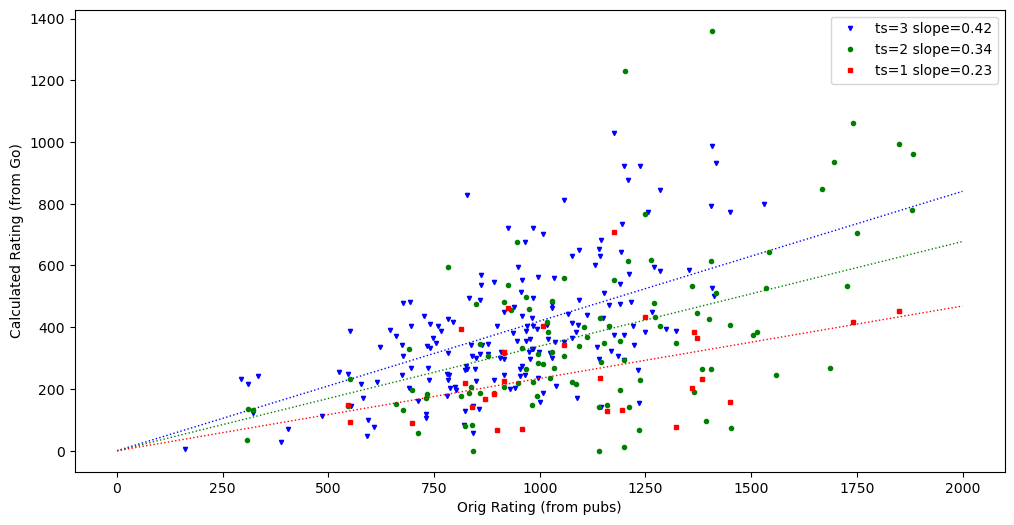

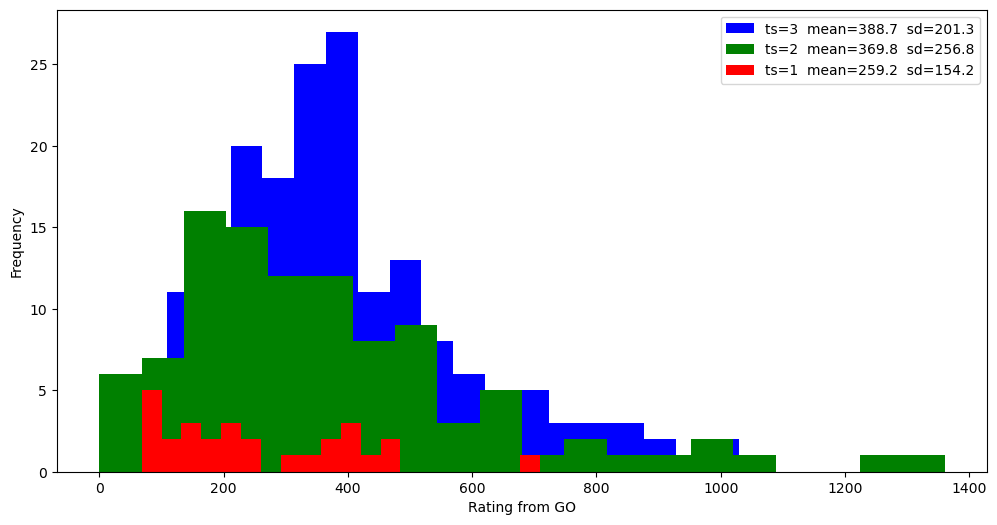

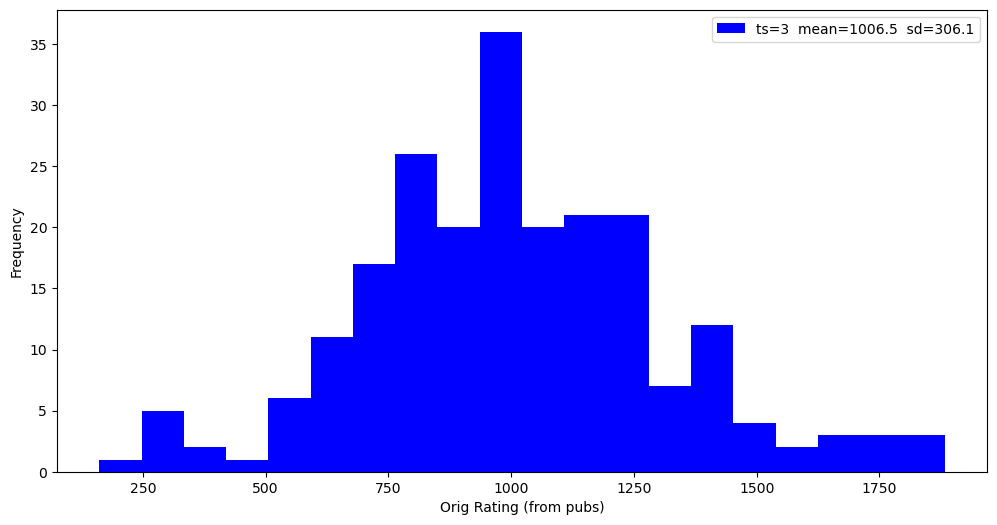

ts_rating_mn_sd = (0, (1006.4660633484162, 306.1465578961359))   (1, (259.16603725867964, 154.234685632133))   (2, (369.7899737274208, 256.77310794716163))   (3, (388.7059324779131, 201.32668550426044))


In [16]:
import matplotlib.pyplot as plt
import numpy as np


marks =  ['', 's', 'o', 'v'] 
colors = ['', 'r', 'g', 'b']

plt.figure(figsize=(12,6))
for ts in [3, 2, 1]:
    x = []
    y = []
    for ign, ts_to_stats in player_stats.items():
        if ign=='TOTALS':
            continue
        if ts not in ts_to_stats: 
            continue
        stats = ts_to_stats[ts]
        if stats.orig_rating is not None and stats.go_rating() is not None:
            x.append(stats.orig_rating)
            y.append(stats.go_rating())

    
    degrees = [1]
    coefs = run_regr(x, y, degrees)
    plot_regr_line(coefs, degrees, xrange=[0,2000], linestyle=':',  color=colors[ts], lw=1)
    
    plt.plot(x, y,             
            marker=marks[ts],
            color=colors[ts],
            markerfacecolor=colors[ts],
            linestyle='None',
            ms=3,
            label=f'ts={ts} slope={coefs[0] :.2f}')

plt.xlabel("Orig Rating (from pubs)")
plt.ylabel("Calculated Rating (from Go)")
plt.legend(numpoints=1)
plt.show()

ts_rating_mn_sd = dict()

plt.figure(figsize=(12,6))
for ts in [3, 2, 1]:
    x = []
    for ign, ts_to_stats in player_stats.items():
        if ign=='TOTALS':
            continue
        if ts not in ts_to_stats: 
            continue
        stats = ts_to_stats[ts]
        if stats.go_rating() is not None:
            x.append(stats.go_rating())
    
    x = np.array(x)
    ts_rating_mn_sd[ts] = (x.mean(), x.std())
    plt.hist(x, bins=20,
            color=colors[ts],
            # histtype='step',
            label=f'ts={ts}  mean={x.mean():.1f}  sd={x.std():.1f}')

plt.xlabel("Rating from GO")
plt.ylabel("Frequency")
plt.legend(numpoints=1)
plt.show()


plt.figure(figsize=(12,6))
x = []
for ign, ts_to_stats in player_stats.items():
    if ign=='TOTALS':
        continue
    for ts,stats in ts_to_stats.items():
        if stats.orig_rating is not None:
            x.append(stats.orig_rating)
            break

x = np.array(x)
ts_rating_mn_sd[0] = (x.mean(), x.std())
plt.hist(x, bins=20,
        color=colors[ts],
        label=f'ts={ts}  mean={x.mean():.1f}  sd={x.std():.1f}')

plt.xlabel("Orig Rating (from pubs)")
plt.ylabel("Frequency")
plt.legend(numpoints=1)
plt.show()

print(f'ts_rating_mn_sd = {"   ".join([str(_) for _ in sorted(ts_rating_mn_sd.items())])}')

VIPxCreamy g=10  wr=0.60  kpg=5.50  dpg=1312  rating=1360.52


/var/folders/k8/nq68wvmn7sl_xpt_6335__nw0000gn/T/ipykernel_28364/2234656205.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coefs, _, _, _ = np.linalg.lstsq(matrix, y)


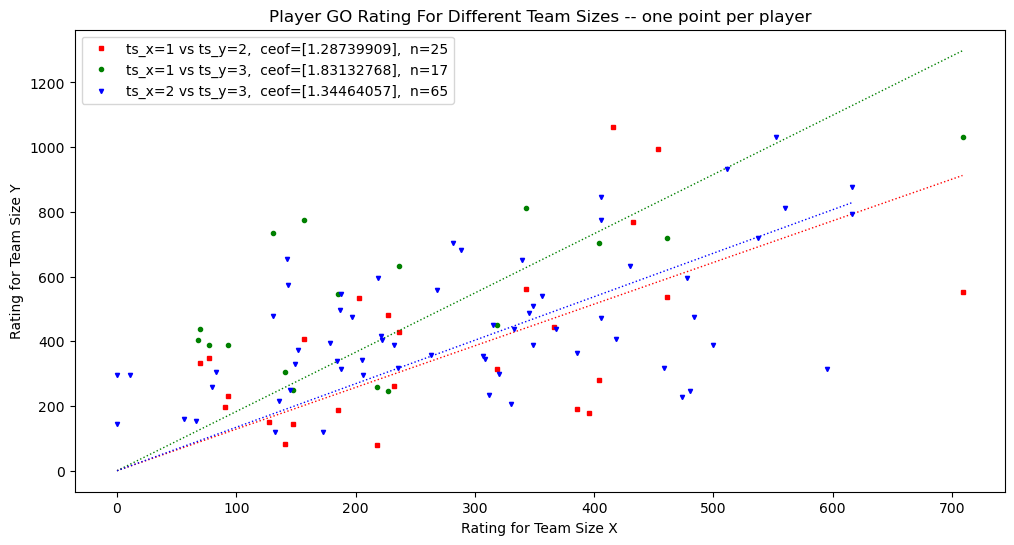

TOTALS 1 g=199  wr=0.02  kpg=1.26  dpg=379  rating=310.86
TOTALS 2 g=478  wr=0.13  kpg=3.38  dpg=1054  rating=880.29
TOTALS 3 g=694  wr=0.15  kpg=4.50  dpg=1426  rating=1176.34
1, 2 --> 1.29   totals_ratio: 2.832
1, 3 --> 1.83   totals_ratio: 3.784
2, 3 --> 1.34   totals_ratio: 1.336


In [17]:

plt.figure(figsize=(12,6))

ts_adjustements = dict()

for tsx,tsy,color,mark in [(1,2,'r','s'), (1,3,'g','o'), (2,3,'b','v')]:
    x = []
    y = []

    for ign, ts_to_stats in sorted(player_stats.items()):
        if ign=="TOTALS":
            continue
        if tsx in ts_to_stats and tsy in ts_to_stats:
            if ts_to_stats[tsx].go_rating() > 800:
                print(ign,ts_to_stats[tsx])
                continue
            x.append(ts_to_stats[tsx].go_rating())
            y.append(ts_to_stats[tsy].go_rating())


    coefs = run_regr(x, y, degrees=[1])
    plot_regr_line(coefs, degrees, linestyle=':', xrange=[0,max(x)], color=color, lw=1)

    ts_adjustements[(tsx,tsy)] = coefs[0]

    plt.plot(x, y,             
            marker=mark,
            color=color,            
            linestyle='None',
            ms=3,
            label=f'ts_x={tsx} vs ts_y={tsy},  ceof={coefs},  n={len(x)}')
    
    
plt.title("Player GO Rating For Different Team Sizes -- one point per player")
plt.xlabel("Rating for Team Size X")
plt.ylabel("Rating for Team Size Y")
plt.legend(numpoints=1)
plt.show()

totals = player_stats['TOTALS']
for ts, stats in sorted(totals.items()):
    print('TOTALS',ts,stats)

for (tsx, tsy), adj in sorted(ts_adjustements.items()):
    print(f'{tsx}, {tsy} --> {adj:.2f}   totals_ratio: {totals[tsy].go_rating() / totals[tsx].go_rating() :.3f}')

In [14]:

ign_to_adj_ratings = defaultdict(lambda: defaultdict(float))

for ign, ts_to_stats in sorted(player_stats.items()):
    orig_rating = None
    
    if ign=="TOTALS":
        continue
    rating_adj_total = 0
    rating_adj_wgt = 0
    for ts,stats in sorted(ts_to_stats.items()):
        orig_rating = stats.orig_rating
        adj = ts_adjustements[(ts,3)] if ts!=3 else 1
        # print(ts,f'{adj:.2f}',f'{stats.games:2}',f'{stats.go_rating():.1f}')
        rating_adj_total += stats.go_rating() * adj * stats.games
        rating_adj_wgt += stats.games
        ign_to_adj_ratings[ign][f'TS_{ts}'] = stats.go_rating()

    rating_adj = 1.0 * rating_adj_total / rating_adj_wgt
    # print(ign,rating_adj,ratings,gs)
    ign_to_adj_ratings[ign]['REGR_COEF'] = rating_adj
    ign_to_adj_ratings[ign]['ORIG'] = orig_rating
    
    zscore_total = 0.0
    zscore_wgt = 0.0
    for ts,stats in sorted(ts_to_stats.items()):
        mn,sd = ts_rating_mn_sd[ts]
        zscore = (stats.go_rating() - mn) / sd
        zscore_total += zscore * stats.games
        zscore_wgt += stats.games
        # print(f'{ign}   {ts=}   g={stats.games:2}   {mn= :.2f}   {sd= :.2f}   {stats.go_rating()}   {zscore= :.2f}')
    zscore = zscore_total / zscore_wgt
    mn,sd = ts_rating_mn_sd[0]    
    confidence_factor = min(1,max(0,zscore_wgt/15.0))
    confidence_factor2 = min(1,max(0,zscore_wgt/30.0))
    
    rating_adj = sd * zscore + mn
    rating_adj_reduced = rating_adj*confidence_factor + (1-confidence_factor)*orig_rating
    rating_adj_reduced2 = rating_adj*confidence_factor2 + (1-confidence_factor2)*orig_rating

    ign_to_adj_ratings[ign]['ZSCORE'] = rating_adj    
    ign_to_adj_ratings[ign]['ZSCORE_REDUCED'] = rating_adj_reduced
    ign_to_adj_ratings[ign]['ZSCORE_REDUCED_ASYM'] = rating_adj_reduced2 if rating_adj < orig_rating else rating_adj_reduced

    ign_to_adj_ratings[ign]['games'] = zscore_wgt    

    # print(f'{ign:12}  {orig_rating= :.2f}   {rating_adj =:.2f}   rating_red={ign_to_adj_ratings[ign]["ZSCORE_REDUCED"] :.2f}   {mn= :.2f}   {sd= :.2f}   {zscore= :.2f}')
    # print()

with open("../go_post_s10_adjusted_ratings.csv", 'w') as f:
    all_keys = set()
    for ign, name_to_adj_ratings in sorted(ign_to_adj_ratings.items()):
        all_keys.update(name_to_adj_ratings.keys())
    # print(f'ign,{",".join(sorted(all_keys))}')
    # header = 'ign,ORIG,TS_1,TS_2,TS_3,REGR_COEF,ZSCORE,ZSCORE_REDUCED'.split(',')
    header = 'ign,games,ORIG,ZSCORE,ZSCORE_REDUCED,ZSCORE_REDUCED_ASYM'.split(',')
    f.write(','.join(header))
    f.write('\n')
    for ign, name_to_adj_ratings in sorted(ign_to_adj_ratings.items()):
        f.write(f'{ign},{",".join([str(name_to_adj_ratings[_]) for _ in header[1:]])}')
        f.write('\n')   
